## Scan Env with LiDAR (Generate Map)

<span style="color:orange;font-size: 20px;font-weight:light;"> Need parameter tuning for correct scanning process </span>

In [1]:
# gap between lidar's scanning positions
LIDAR_POS_GAP = 0.5
# stop generate new lidar path when detect obstacles
OBSTACLE_DETECTION_DISTANCE = 0.2

# lidar initial position (lidar will move only on xy plane, while z fixed)
x_pos = -1.0
y_pos = -3.5
z_pos = 0.1

# number of lidars
lidar_number = 1
# lidar properties


objc[24665]: Class GLFWApplicationDelegate is implemented in both /opt/homebrew/anaconda3/envs/mujoco301Python310/lib/python3.10/site-packages/open3d/cpu/pybind.cpython-310-darwin.so (0x10debee28) and /opt/homebrew/anaconda3/envs/mujoco301Python310/lib/python3.10/site-packages/glfw/libglfw.3.dylib (0x1690d5bd0). One of the two will be used. Which one is undefined.
objc[24665]: Class GLFWWindowDelegate is implemented in both /opt/homebrew/anaconda3/envs/mujoco301Python310/lib/python3.10/site-packages/open3d/cpu/pybind.cpython-310-darwin.so (0x10debedb0) and /opt/homebrew/anaconda3/envs/mujoco301Python310/lib/python3.10/site-packages/glfw/libglfw.3.dylib (0x1690d5bf8). One of the two will be used. Which one is undefined.
objc[24665]: Class GLFWContentView is implemented in both /opt/homebrew/anaconda3/envs/mujoco301Python310/lib/python3.10/site-packages/open3d/cpu/pybind.cpython-310-darwin.so (0x10debee50) and /opt/homebrew/anaconda3/envs/mujoco301Python310/lib/python3.10/site-packages/g

MuJoCo:[3.1.6]
name:[Tabletop] dt:[0.002] HZ:[500]
n_qpos:[85] n_qvel:[82] n_qacc:[82] n_ctrl:[0]

n_body:[428]
 [0/428] [world] mass:[0.00]kg
 [1/428] [wall_back1_backing_outer_wall_backings_main] mass:[8864.64]kg
 [2/428] [wall_back2_backing_outer_wall_backings_main] mass:[1736.64]kg
 [3/428] [wall_front1_backing_outer_wall_backings_main] mass:[4782.24]kg
 [4/428] [wall_front2_backing_outer_wall_backings_main] mass:[5754.24]kg
 [5/428] [wall_left1_backing_outer_wall_backings_main] mass:[4847.04]kg
 [6/428] [wall_left2_backing_outer_wall_backings_main] mass:[2643.84]kg
 [7/428] [wall_right1_backing_outer_wall_backings_main] mass:[4587.84]kg
 [8/428] [wall_right2_backing_outer_wall_backings_main] mass:[2643.84]kg
 [9/428] [wall1_backing_inner_wall_backings_main] mass:[3291.84]kg
 [10/428] [wall2_backing_inner_wall_backings_main] mass:[3291.84]kg
 [11/428] [wall3_backing_inner_wall_backings_main] mass:[2643.84]kg
 [12/428] [bedroom_door_backing_door_wall_backings_main] mass:[176.00]kg
 

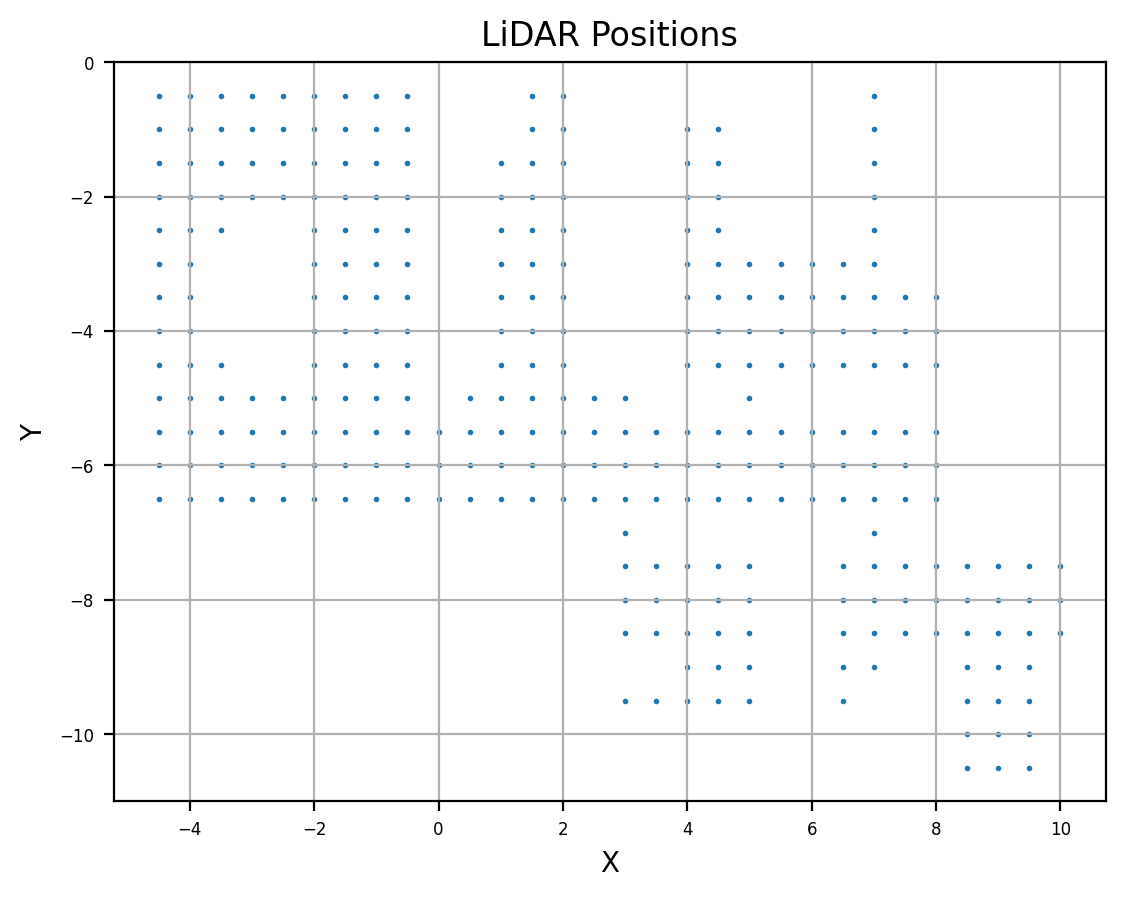

In [2]:
import open3d as o3d
import mujoco,sys
import numpy as np
import matplotlib.pyplot as plt
import time
from utils import *
sys.path.append('../package/helper/')
sys.path.append('../package/mujoco_usage/')
from mujoco_parser import *
from transformation import *
from slider import *
from utility import *

np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo:[%s]"%(mujoco.__version__))

preprocessed_xml_name = "../xml/casa_scenes_transitional_1_site_v3_with_lidar.xml"
mujoco_env = MuJoCoParserClass(name='Tabletop',rel_xml_path=preprocessed_xml_name,verbose=True)

point_cloud = o3d.geometry.PointCloud()

print ("Done.")

render_HZ = 50
render_dt = 1./render_HZ
t_render = time.time()
t_render_prev = time.time()

# Reset
np.random.seed(seed=0)
mujoco_env.reset()

# Loop
mujoco_env.init_viewer(title='Lidar Auto-Scan',
                transparent=False,distance=3.0)

initial_point = [x_pos, y_pos, z_pos]
directions = np.array([[1, 0, 0], [-1, 0, 0], [0, 1, 0], [0, -1, 0]])
expanded_points = set()
expanded_points.add(tuple(initial_point))
current_points = {tuple(initial_point)}
mujoco_env.move_mocap(initial_point)

while mujoco_env.is_viewer_alive():
    contact_points = np.zeros((360, 3))
    start_time = time.time()
    while current_points:
        new_points = set()
        for point in current_points:
            expanded, point_cloud = expand_points(np.array(point), mujoco_env, render_HZ,LIDAR_POS_GAP, OBSTACLE_DETECTION_DISTANCE, directions, point_cloud, contact_points)
            new_points.update(expanded)
        current_points = new_points - expanded_points
        expanded_points.update(current_points)
        current_time = time.time()
        if current_time - start_time >= 1:
            print("expanded_points : ", len(expanded_points))
            start_time = current_time 
    mujoco_env.close_viewer()
    
# Results
lidar_positions = np.array(list(expanded_points))

import matplotlib.pyplot as plt
x = lidar_positions[:, 0]
y = lidar_positions[:, 1]
# Plot
plt.scatter(x, y, s=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('LiDAR Positions')
plt.grid(True)
plt.show()

### Save Point Cloud

In [3]:
from datetime import datetime
import os
now = datetime.now()
# pointcloud_name =preprocessed_xml_name.replace(".xml", "")
# pointcloud_name = preprocessed_xml_name.split('../xml/')[1]
pointcloud_name = preprocessed_xml_name.replace('../xml/','')
pointcloud_name = pointcloud_name.replace('.xml','')
pointcloud_name = pointcloud_name.replace("/", "_") + now.strftime("_%Y%m%d_%H%M%S") + ".ply"
pointcloud_file_path = "./point_cloud/" + pointcloud_name

directory = os.path.dirname(pointcloud_file_path)
if not os.path.exists(directory):
    os.makedirs(directory)
o3d.io.write_point_cloud(pointcloud_file_path, point_cloud)

True

In [4]:
import open3d as o3d

# Specify the file path
file_path = pointcloud_file_path

# Load the point cloud data
loaded_point_cloud = o3d.io.read_point_cloud(file_path)

# Print some information about the loaded point cloud
print(f"Loaded point cloud with {len(loaded_point_cloud.points)} points")
def close_visualizer(vis):
    vis.destroy_window()

# Create a visualizer
vis = o3d.visualization.VisualizerWithKeyCallback()
vis.create_window()
vis.add_geometry(loaded_point_cloud)
vis.register_key_callback(ord('Q'), close_visualizer)
vis.register_key_callback(ord('q'), close_visualizer)
vis.run()
vis.destroy_window()

Loaded point cloud with 3821 points
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


2024-10-16 16:07:25.000 python[24665:1186284] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


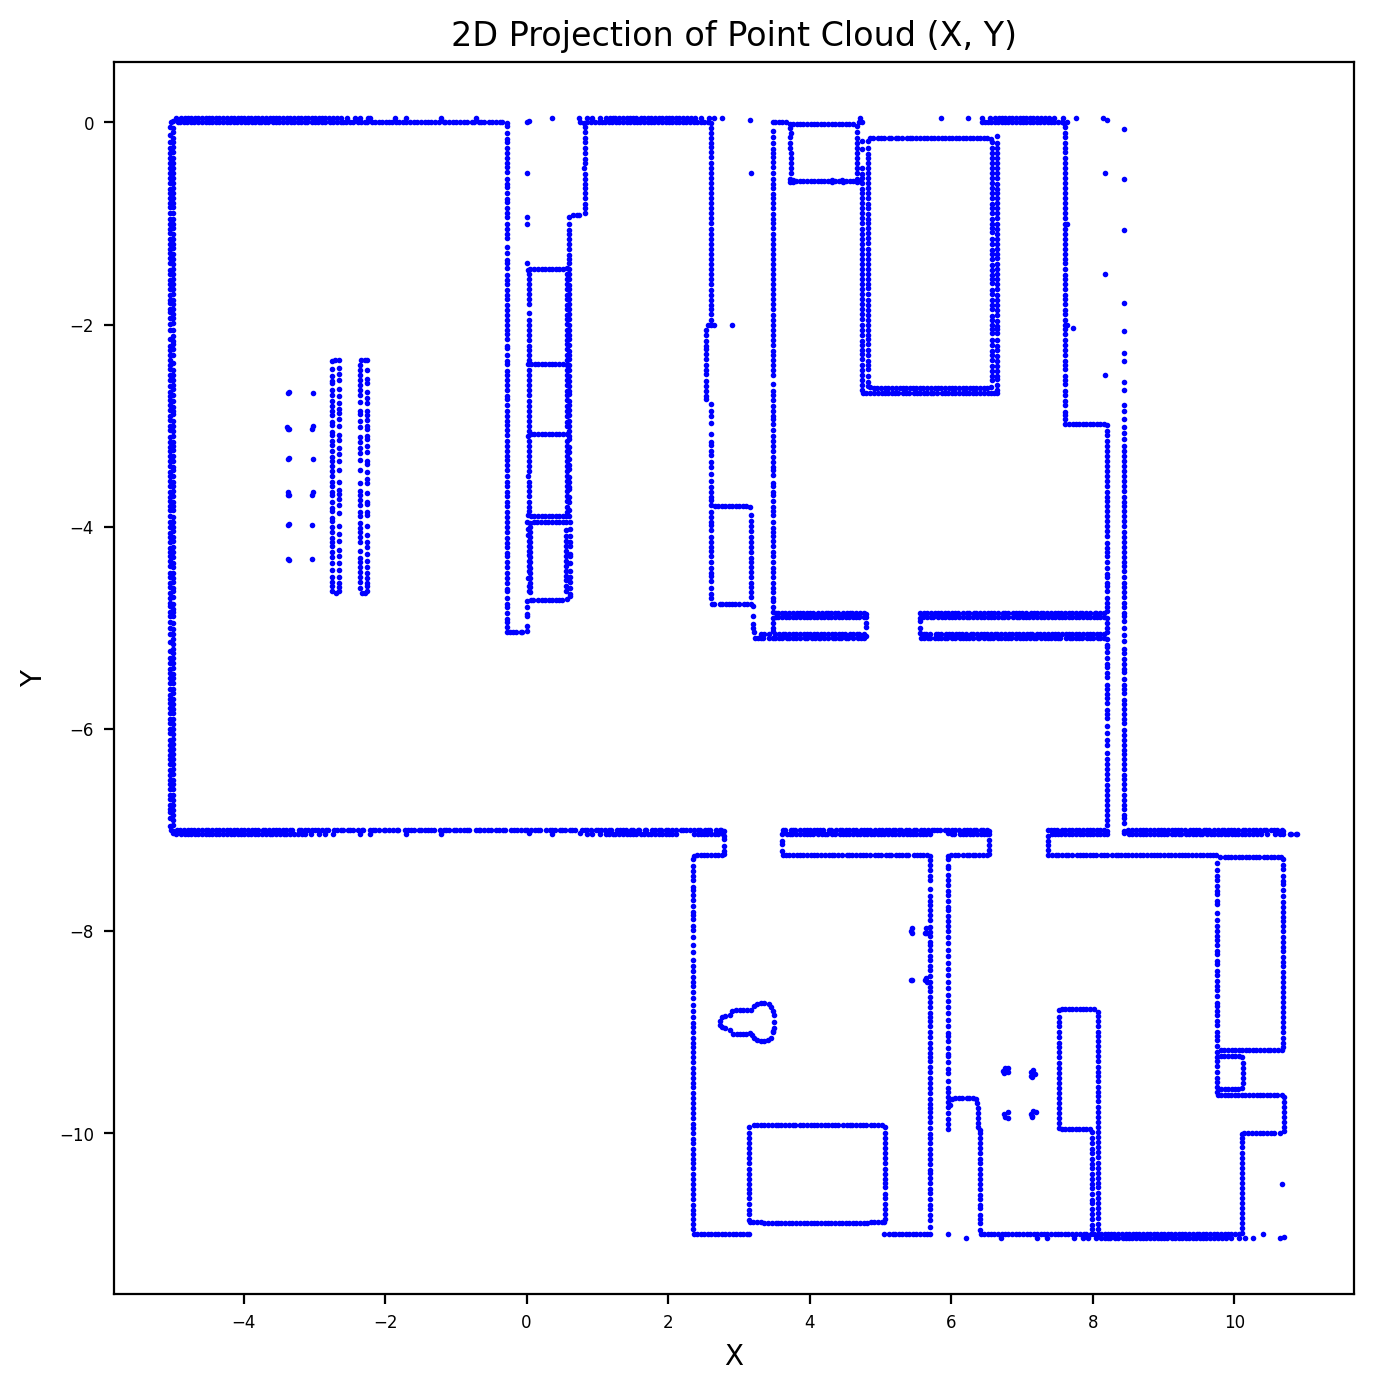

In [6]:
import matplotlib.pyplot as plt
import open3d as o3d

# Specify the file path
file_path = pointcloud_file_path

# Load the point cloud data
loaded_point_cloud = o3d.io.read_point_cloud(file_path)

points = loaded_point_cloud.points
# Separate X, Y (ignore Z)
x_vals = [point[0] for point in points]
y_vals = [point[1] for point in points]

# Plot the XY points in a scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(x_vals, y_vals, s=1, c='b')  # s=1 for point size, c='b' for blue color
plt.title('2D Projection of Point Cloud (X, Y)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()